# Introduction  

Attempt to model a customer’s propensity to join our loyalty program.  

Import necessary modules:

In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy import stats
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.cluster import MeanShift, estimate_bandwidth
%matplotlib inline

# Import and explore data

Read the data into notebook:

In [2]:
url = "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/customers_data.csv"
df = pd.read_csv(url)

Show last lines of dataframe:

In [3]:
df.tail(5)

,Unnamed: 0,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
119995,119995,55.33,female,yes,22.0,41.0,False
119996,119996,55.86,male,yes,22.0,58.0,False
119997,119997,30.16,male,yes,25.0,79.0,False
119998,119998,2.71,female,yes,25.0,60.0,False
119999,119999,62.75,female,yes,21.0,50.0,False


Check for null values:

In [4]:
df.isnull().sum()

Unnamed: 0               0
purch_amt                0
gender                   0
card_on_file             0
age                      0
days_since_last_purch    0
loyalty                  0
dtype: int64

Look at the shape of the dataframe:

In [5]:
df.shape

(120000, 7)

Check out some of the distributions:

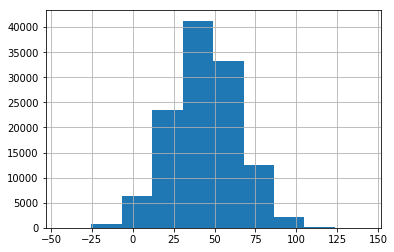

In [6]:
df.purch_amt.hist()

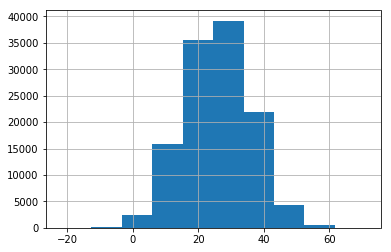

In [7]:
df.age.hist()

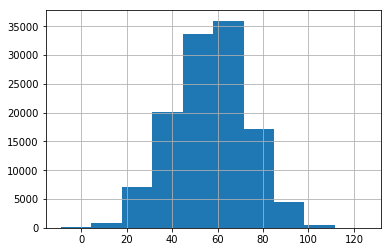

In [8]:
df.days_since_last_purch.hist()

The above features look normally distributed.  Next drop some columns to produce a pairplot:

In [9]:
# make a copy of the dataframe for the pairplot
df_pp = df.copy()

# set the pairplot parameters
df_pp.drop(['Unnamed: 0'], axis=1, inplace=True)
df_pp.drop(['gender'], axis=1, inplace=True)
df_pp.drop(['card_on_file'], axis=1, inplace=True)

# drop Unnamed column in origianl df:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# convert loyalty to 0 or 1 for pairplot and original dataframe:
df_pp.loyalty = df.loyalty.astype(int)
df.loyalty = df.loyalty.astype(int)

# convert gender and card_on_file to binary
df.gender.replace('male', 1, inplace=True)
df.gender.replace('female', 0, inplace=True)

df.card_on_file.replace('yes', 1, inplace=True)
df.card_on_file.replace('no', 0, inplace=True)

In [10]:
df.head()

,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
0,19.58,1,0,31.0,35.0,0
1,65.16,1,1,23.0,61.0,0
2,40.60,0,0,36.0,49.0,0
3,38.01,1,1,47.0,57.0,0
4,22.32,0,1,5.0,39.0,0


In [11]:
df_pp.head()

,purch_amt,age,days_since_last_purch,loyalty
0,19.58,31.0,35.0,0
1,65.16,23.0,61.0,0
2,40.60,36.0,49.0,0
3,38.01,47.0,57.0,0
4,22.32,5.0,39.0,0


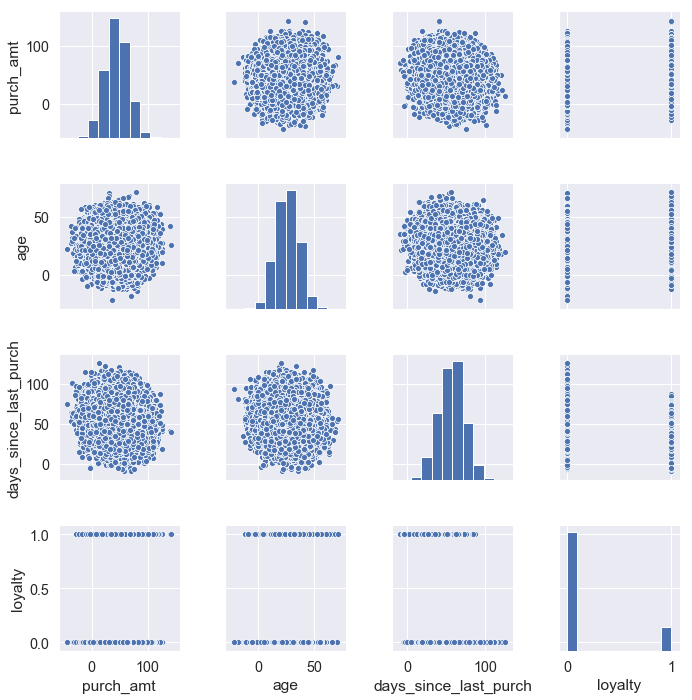

In [12]:
sns.set(font_scale=1.3)
sns.pairplot(df_pp)
plt.show()

A loyalty of True already shows lower distribution of 'days_since_last_purch', higher 'age' and higher 'purch_amt'.  Other, feature relationships look random and uncorrelated to one another.  Calculate some statistics to check for significant features -  'purch_amt', 'age', 'days_since_last_purch':

In [13]:
print(df.purch_amt.where(df.loyalty == 1).dropna().mean())
print(df.purch_amt.where(df.loyalty == 0).dropna().mean())

53.9338424999999
42.056711800000286


Is this mean difference significant ?  Execute the t-test:

In [14]:
ttest_ind(df.purch_amt.where(df.loyalty == 1).dropna(), df.purch_amt.where(df.loyalty == 0).dropna())

Ttest_indResult(statistic=76.70870970381057, pvalue=0.0)

Yes, this is definitely significant; pvalue = 0, so age is a factor when determining loyalty.

In [15]:
print(df.age.where(df.loyalty == 1).mean())
print(df.age.where(df.loyalty == 0).mean())

29.8909
24.98543


In [16]:
ttest_ind(df.age.where(df.loyalty == 1).dropna(), df.age.where(df.loyalty == 0).dropna())

Ttest_indResult(statistic=63.410718666477926, pvalue=0.0)

Age is also definitely significant since pvalue is way, less than 0.05.

In [17]:
print(df.days_since_last_purch.where(df.loyalty == 1).mean())
print(df.days_since_last_purch.where(df.loyalty == 0).mean())

39.824
59.96229


In [18]:
ttest_ind(df.days_since_last_purch.where(df.loyalty == 1).dropna(), df.days_since_last_purch.where(df.loyalty == 0).dropna())

Ttest_indResult(statistic=-177.98662169196214, pvalue=0.0)

Days since last purchase is also definitely signigicant.

Check for balance or unbalanced data:

In [19]:
df.loyalty.value_counts()

0    100000
1     20000
Name: loyalty, dtype: int64

Unbalanced data, so next step is to balance by randomly dropping 80% of the False values.

In [20]:
df.drop(df[df.loyalty.eq(False)].sample(frac=.8).index, inplace=True)

In [21]:
df.head(10)

,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
1,65.16,1,1,23.0,61.0,0
9,93.63,0,0,40.0,47.0,1
11,28.05,1,1,14.0,46.0,0
13,64.91,1,1,22.0,59.0,1
17,42.50,1,0,37.0,64.0,0
19,52.50,0,1,11.0,58.0,0
23,11.55,1,0,21.0,53.0,1
28,40.64,0,0,20.0,29.0,1
35,64.07,1,0,10.0,62.0,1
38,15.26,1,0,33.0,81.0,0


Checking again for balance:

In [22]:
df.loyalty.value_counts()

1    20000
0    20000
Name: loyalty, dtype: int64

Now data is balanced by randomly dropping 80% of False values.  

# Build the model  

First, separate training and test groups:

In [23]:
# Create training and test sets.
offset = int(df.shape[0] * 0.8)

df_train = df[:offset]
df_test = df[offset:]

print(df_train.shape)
print(df_test.shape)

(32000, 6)
(8000, 6)


#### Logistic Regression

In [24]:
# 1.  Logistic Regression

from datetime import datetime
start_time = datetime.now()

# Instantiate our model.
regr = linear_model.LogisticRegression()

# set features and dependent variable for training data
y_train = df_train['loyalty'].values

# drop the 'binary' column to obtain the feature inputs
df_train.drop(['loyalty'], axis=1, inplace=True)

# normalize the training data
x_train = sklearn.preprocessing.normalize(df_train)

# now for test...
y_test = df_test['loyalty'].values

# drop the 'binary' column to obtain the feature inputs
df_test.drop(['loyalty'], axis=1, inplace=True)

# normalize the test data
x_test = sklearn.preprocessing.normalize(df_test)

# fit model to training data
regr.fit(x_train, y_train)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Duration: 0:00:00.196011


C:\Users\Fred\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Fred\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Fred\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [25]:
# Display the attributes calculated.
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)

# print the area under the curve score for the accuracy metric
y_test_pred = regr.predict(x_test)
print(sklearn.metrics.roc_auc_score(y_test, y_test_pred))

# print the consfusion matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)

Coefficients: 
 [[ 0.66820666  2.36298493  2.65450701  3.74884777 -8.44510232]]
Intercept: 
 [3.65627131]
0.7847512847512848


array([[3141,  855],
       [ 867, 3137]], dtype=int64)

#### Random Forest Classifier

In [26]:
# 2.  Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

# Instantiate our model.
rfc = RandomForestClassifier(n_estimators=500, max_depth=50)

# fit model to data
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [27]:
# print the area under the curve score for the accuracy metric
y_test_pred = rfc.predict(x_test)
print(sklearn.metrics.roc_auc_score(y_test, y_test_pred))

# print the consfusion matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)

0.7723648973648973


array([[3046,  950],
       [ 871, 3133]], dtype=int64)

#### Gradient Boosting Clasifier

In [28]:
# 3.  Gradient Boosting Classifier

from sklearn.ensemble import GradientBoostingClassifier

# Instantiate our model.
gbc = GradientBoostingClassifier(n_estimators=500)

# fit model to data
gbc.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [29]:
# print the area under the curve score for the accuracy metric
y_test_pred = gbc.predict(x_test)
print(sklearn.metrics.roc_auc_score(y_test, y_test_pred))

# print the consfusion matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)

0.7883604133604134


array([[3092,  904],
       [ 789, 3215]], dtype=int64)

# Evaluation and conclusion  

Used 3 models: Logistic Regression, Random Forest and Gradient Boosting classifier algorithms.  The ground truth accuracy rating would be 0.50, so these models are performaing fairly well.  The results are as follows:

- Logistic Regression:  accuracy for test is **0.79**  
- Random Forest Classifier:  accuracy for test is **0.78**  
- Gradient Boosting Classifier:  accuracy for test is **0.79**  

First tested without including the features 'gender' and 'card_on_file'.  The results were very similar, however, the RFC did improve from about 0.73 to 0.78.  

The data was unbalanced, so 80% of the False loyalty values were dropped.  There still remained 20,000 values for each case (True or False), so this is still a good amount to build models with.  Another option would have been to multiply the number of True rows by 5 to obtain a balanced dataset.  

To summarize, using the above models, the accuracy to predict whether a customer would join the loyalty program is just under 80% which is better than the ground truth of 50%.  Also, if one would have chosen all 'False' as a prediction of loyalty from the original dataset, this would have obtained an accuracy of 80% without doing any model building whatsoever.  However, all of the error would be the generetion of False Positives and there would be 0 True Positives which is the purpose of the study.  This would not be helpful.

In the models produced above, there are a healthy number of True Positives; and the False Negatives and False Positives in the Confusion Matrix are fairly equally distributed.